In [146]:
try:
    import luas
except ImportError:
    !git clone https://github.com/markfortune/luas.git
    %cd luas
    %pip install .
    %cd ..

try:
    import jaxoplanet
except ImportError:
    %pip install -q jaxoplanet

try:
    import pymc
except ImportError:
    %pip install -q pymc
    
try:
    import corner
except ImportError:
    %pip install -q corner

(pymc_example)=

# PyMC Example: Transmission Spectroscopy

*NOTE: This tutorial notebook is currently in development. Expect significant changes in the future*

This notebook provides to tutorial on how to use ``PyMC`` to perform spectroscopic transit light curve fitting. We will first go through how to generate transit light curves in ``JAX``, then we will create synthetic noise which will be correlated in both wavelength and time. Finally we will use ``PyMC`` to fit the noise contaminated light curves and recover the input transmission spectrum.

If you have a GPU available (including if running on Google Colab) then ``jax`` should detect this and run automatically. Running ``jax.devices()`` tells us what ``jax`` has found to run on. If there is a GPU available but it is not detected this could indicate ``jax`` has not been correctly installed for GPU. Also note if running on Google Colab that the T4 GPUs have poor performance at double precision floating point and may not show significant speed-ups, while more modern hardware such as NVIDIA Tesla V100s or better tend to show significant performance improvements

In [34]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os.path
import logging
from jaxoplanet.orbits import KeplerianOrbit
from jaxoplanet.light_curves import QuadLightCurve
import arviz as az
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# This helps give more information on what PyMC is doing during inference
logging.getLogger().setLevel(logging.INFO)

# Running this at the start of the runtime ensures jax uses 64-bit floating point numbers
# as jax uses 32-bit by default
jax.config.update("jax_enable_x64", True)

# This will list available CPUs/GPUs JAX is picking up
print("Available devices:", jax.devices())

Available devices: [CpuDevice(id=0)]


First we will use [jaxoplanet](https://github.com/exoplanet-dev/jaxoplanet) which has its own documentation and tutorials [here](https://jax.exoplanet.codes/en/latest/).

First let's create a single light curve with quadratic limb darkening. We will use the ``transit_light_curve`` function from ``luas.exoplanet`` which is included here for convenience:

In [2]:
def transit_light_curve(par, t):
    """Uses the package `jaxoplanet <https://github.com/exoplanet-dev/jaxoplanet>`_ to calculate
    transit light curves using JAX assuming quadratic limb darkening and a simple circular orbit.
    
    This particular function will only compute a single transit light curve but JAX's vmap function
    can be used to calculate the transit light curve of multiple wavelength bands at once.
    
    Args:
        par (PyTree): The transit parameters stored in a PyTree/dictionary (see example above).
        t (JAXArray): Array of times to calculate the light curve at.
            
    Returns:
        JAXArray: Array of flux values for each time input.
        
    """
    
    light_curve = QuadLightCurve.init(u1=par["u1"], u2=par["u2"])
    orbit = KeplerianOrbit.init(
        time_transit=par["T0"],
        period=par["P"],
        semimajor=par["a"],
        impact_param=par["b"],
        radius=par["rho"],
    )
    
    flux = (par["Foot"] + 24*par["Tgrad"]*(t-par["T0"]))*(1+light_curve.light_curve(orbit, t)[0])
    
    return flux

INFO:absl:Remote TPU is not linked into jax; skipping remote TPU.
INFO:absl:Unable to initialize backend 'tpu_driver': Could not initialize backend 'tpu_driver'
INFO:absl:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:absl:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


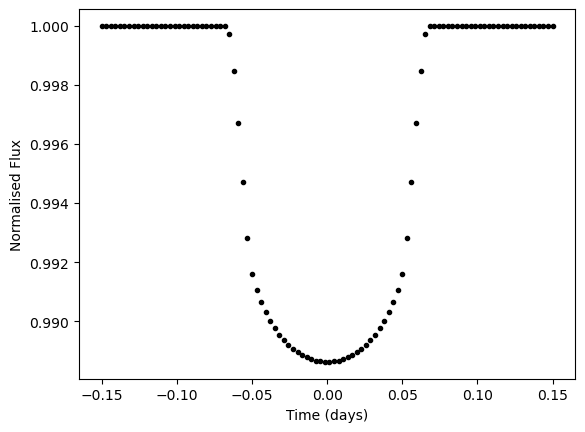

In [3]:
from luas.exoplanet import transit_light_curve

# Let's use the literature values used in Gibson et al. (2017) to start us off
mfp = {
    "T0":0.,       # Central transit time
    "P":3.4,  # Period (days)
    "a":8.,      # Semi-major axis to stellar ratio aka a/R*
    "rho":0.1, # Radius ratio rho aka Rp/R*
    "b":0.5,     # Impact parameter
    "u1":0.5,    # First quadratic limb darkening coefficient
    "u2":0.1,    # Second quadratic limb darkening coefficient
    "Foot":1.,     # Baseline flux out of transit
    "Tgrad":0.     # Gradient in baseline flux (hrs^-1)
}

# Generate 100 evenly spaced time points (in units of days)
N_t = 100
x_t = jnp.linspace(-0.15, 0.15, N_t)

plt.plot(x_t, transit_light_curve(mfp, x_t), "k.")
plt.xlabel("Time (days)")
plt.ylabel("Normalised Flux")
plt.show()

Now we want to take our ``jax`` function which has been written to generate a 1D light curve in time and instead create separate light curves in each wavelength. We also will want to share some parameters between light curves (e.g. impact parameter b, system scale a/Rs) while varying other parameters for each wavelength (e.g. radius ratio Rp/Rs).

We could of course write a for loop but for loops can be slow to compile with ``jax``. A much more efficient option is to make use of ``jax.vmap`` function which allows us to "vectorise" our function from 1D to 2D:

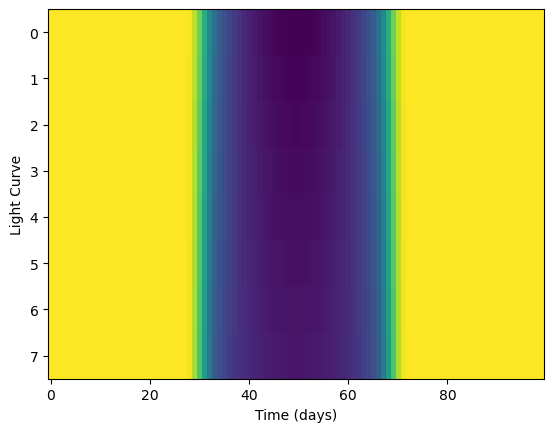

In [35]:
# First we must tell JAX which parameters of the function we want to vary for each light curve
# and which we want to be shared between light curves
transit_light_curve_vmap = jax.vmap(
    # First argument is the function to vectorise
    transit_light_curve, 
    
    # Specify which parameters to share and which to vary for each light curve
    in_axes=(
        {
        # If a parameter is to be shared across each light curve then it should be set to None
        "T0":None, "P":None, "a":None, "b":None,

        # Parameters which vary in wavelength are given the dimension of the array to expand along
        # In this case we are expanding from 0D arrays to 1D arrays so this must be 0
        "rho":0, "u1":0, "u2":0, "Foot":0, "Tgrad":0
        },
        # Also must specify that we will share the time array (the second function parameter)
        # between light curves
         None,  
    ),
    
    # Specify the output dimension to expand along, this will default to 0 anyway
    # Will output extra flux values for each light curve as additional rows
    out_axes = 0,
)

# Let's define a wavelength range of our data, this isn't actually used by our mean function
# but we will use it for defining correlation in wavelength later
N_l = 8 # Feel free to vary the number of light curves, even >100 light curves may perform quite efficiently
x_l = np.linspace(4000, 7000, N_l)

# Now we define our 2D transit parameters, let's just assume everything is constant in wavelength
mfp_2D = {
    "T0":0.,                         # Central transit time
    "P":3.4,                         # Period (days)
    "a":8.,                          # Semi-major axis to stellar ratio aka a/R*
    "rho":0.1*np.ones(N_l),          # Radius ratio rho aka Rp/R*
    "b":0.5,                       # Impact parameter
    "u1":np.linspace(0.7, 0.4, N_l), # First quadratic limb darkening coefficient
    "u2":np.linspace(0.1, 0.2, N_l), # Second quadratic limb darkening coefficient
    "Foot":1.*np.ones(N_l),          # Baseline flux out of transit
    "Tgrad":0.*np.ones(N_l)          # Gradient in baseline flux (days^-1)
}

# Call our new vmap of transit_light_curve to simultaneously compute light curves for all wavelengths
transit_model_2D = transit_light_curve_vmap(mfp_2D, x_t)

# Plot the data on the left and the multiwavelength model on the right
plt.imshow(transit_model_2D, aspect = 'auto')
plt.xlabel("Time (days)")
plt.ylabel("Light Curve")
plt.show()

The form of a mean function with ``luas.GP`` is ``f(par, x_l, x_t)`` where ``par`` is a PyTree, ``x_l`` is a JAXArray of inputs that lie along the wavelength/vertical dimension of the data (e.g. an array of wavelength values) and ``x_t`` is a JAXArray of inputs that lie along the time/horizontal dimension (e.g. an array of timestamps). Our transit model does not require wavelength values to be computed but we still write our wrapper function to be of this form.

Note our ``jax.vmap`` function specifies exactly the keys that must be in the input PyTree for ``transit_light_curve_vmap`` so we also filter only these parameters to be input into the ``transit_light_curve_vmap`` function

Below is a simple mean function which is compatible with ``luas``. You can also use ``luas.exoplanet.transit_2D`` although note that this fits for transit depth instead of radius ratio

In [36]:
from luas.exoplanet import ld_to_kipping, ld_from_kipping

def transit_2D(p, x_l, x_t):
    
    # vmap requires that we only input the parameters which have been explicitly defined how they vectorise
    transit_params = ["T0", "P", "a", "rho", "b", "Foot", "Tgrad"]
    mfp = {k:p[k] for k in transit_params}
    
    # Calculate limb darkening coefficients from the Kipping (2013) parameterisation.
    mfp["u1"], mfp["u2"] = ld_from_kipping(p["q1"], p["q2"])
    
    # Use the vmap of transit_light_curve to calculate a 2D array of shape (M, N) of flux values
    # For M wavelengths and N time points.
    return transit_light_curve_vmap(mfp, x_t)


# Switch to Kipping parameterisation
if "u1" in mfp_2D:
    mfp_2D["q1"], mfp_2D["q2"] = ld_to_kipping(mfp_2D["u1"], mfp_2D["u2"])
    del mfp_2D["u1"]
    del mfp_2D["u2"]

M = transit_2D(mfp_2D, x_l, x_t)

Now that we have our mean function created, it's time to start building a kernel function. We will try keep things simple and use a squared exponential kernel for correlation in both time and wavelength, and white noise which varies in amplitude between light curves

$$
\begin{equation}
\mathbf{K}_{ij} = h^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda}^2}\right) \exp\left(-\frac{|t_i - t_j|^2}{2 l_{t}^2}\right) + \sigma_{\lambda_i}^2\delta_{\lambda_i \lambda_j} \delta_{t_i t_j}
\end{equation}
$$

This kernel contains a correlated noise component with height scale $h$, length scale in wavelength $l_\mathrm{\lambda}$ and length scale in time $l_t$. There is also a white noise term which can have different white noise amplitudes at different wavelengths.

We will need to write this kernel as separate wavelength and time kernel functions multiplied together satisfying:
$$
\begin{equation}
\text{K}(\Delta \lambda, \Delta t) = \text{K}_{l}(\Delta \lambda) \otimes \text{K}_{t}(\Delta t) + \text{S}_{l}(\Delta \lambda) \otimes \text{S}_{t}(\Delta t)
\end{equation}
$$

We can do this by choosing the equations below for our kernel functions which generate each component matrix. Note that for numerical stability reasons it's important that the $S_l$ and $S_t$ matrices are well-conditioned while $K_l$ and $K_t$ do not need to be well-conditioned and in fact don't even need to be invertible (they still must be positive semi-definite and symmetric)
$$
\begin{equation}
    \text{K}_l(\lambda_i, \lambda_j) = h^2 \exp\left(-\frac{|\lambda_i - \lambda_j|^2}{2 l_\mathrm{\lambda}^2}\right) 
\end{equation}
$$

$$
\begin{equation}
    \text{K}_t(t_i, t_j) = \exp\left(-\frac{|t_i - t_j|^2}{2 l_{t}^2}\right)
\end{equation}
$$

$$
\begin{equation}
    \text{S}_l(\lambda_i, \lambda_j) = \sigma_{\lambda_i}^2\delta_{\lambda_i \lambda_j}
\end{equation}
$$

$$
\begin{equation}
    \text{S}_t(t_i, t_j) = \delta_{t_i t_j}
\end{equation}
$$

In [37]:
from luas import kernels
from luas import LuasKernel

# We implement each of these kernel functions below using the luas.kernels module
# for an implementation of the squared exponential kernel

def Kl_fn(hp, x_l1, x_l2, wn = True):
    Kl = jnp.exp(2*hp["log_h"])*kernels.squared_exp(x_l1, x_l2, jnp.exp(hp["log_l_l"]))
    return Kl

def Kt_fn(hp, x_t1, x_t2, wn = True):
    return kernels.squared_exp(x_t1, x_t2, jnp.exp(hp["log_l_t"]))

# For both the Sl and St functions we set a decomp attribute to "diag" because they produce diagonal matrices
# This speeds up the log likelihood calculations as it tells luas these matrices are easy to eigendecompose
# But don't do this for the Kl and Kt functions even if they produce diagonal matrices unless you know what you are doing
# This is because you are telling luas that the transformations of Kl and Kt are diagonal, not Kl and Kt themselves

def Sl_fn(hp, x_l1, x_l2, wn = True):
    Sl = jnp.zeros((x_l1.shape[-1], x_l2.shape[-1]))
    if wn:
        Sl += jnp.diag(jnp.exp(2*hp["log_sigma"]))

    return Sl
Sl_fn.decomp = "diag" # Sl is a diagonal matrix

def St_fn(p, x_t1, x_t2, wn = True):
    return jnp.eye(x_t1.shape[-1])
St_fn.decomp = "diag" # St is a diagonal matrix

# Build a LuasKernel object using these component kernel functions
# The full covariance matrix applied to the data will be K = Kl KRON Kt + Sl KRON St
kernel = LuasKernel(Kl = Kl_fn, Kt = Kt_fn, Sl = Sl_fn, St = St_fn,
                    
                    # Can select whether to use previously calculated eigendecompositions when running MCMC
                    # Performs an additional check in each step to see if each component covariance matrix has changed since last step
                    # Useful when doing blocked Gibbs or if fixing some hyperparameters
                    use_stored_values = True, 
                   )

The ``LuasKernel.visualise_covariance_matrix`` method should be a useful way of visualising each of the four component matrices and ensure everything you have written looks right

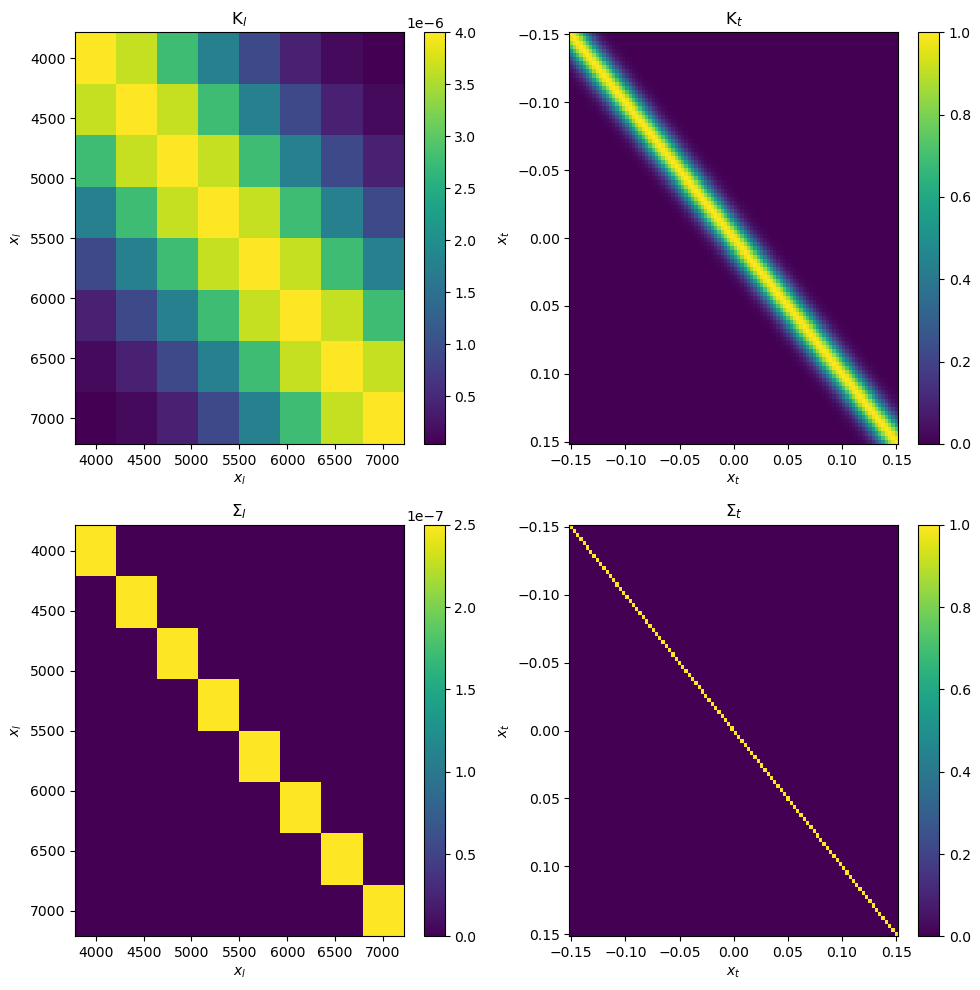

In [38]:
hp = {
    "log_h":np.log(2e-3),
    "log_l_l":np.log(1000.),
    "log_l_t":np.log(0.011),
    "log_sigma":np.log(5e-4)*np.ones(N_l),
}

kernel.visualise_covariance_matrix(hp, x_l, x_t);

Take a random noise draw from this covariance matrix. Try playing around with these values to see the effect varying each parameter has on the noise generated.

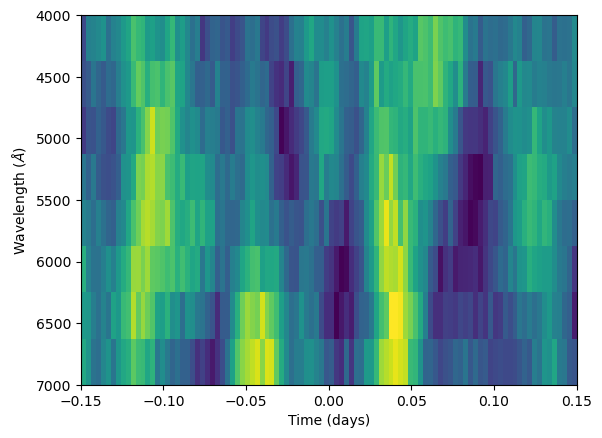

In [39]:
hp = {"log_h":np.log(2e-3), "log_l_l":np.log(1000.), "log_l_t":np.log(0.011),
      "log_sigma":np.log(5e-4)*np.ones(N_l),}

sim_noise = kernel.generate_noise(hp, x_l, x_t)

plt.imshow(sim_noise, aspect = 'auto', extent = [x_t[0], x_t[-1], x_l[-1], x_l[0]])
plt.xlabel("Time (days)")
plt.ylabel("Wavelength ($\AA$)")
plt.show()

Combining our light curves and noise model we can generate synthetic light curves contaminated by systematics correlated in time and wavelength

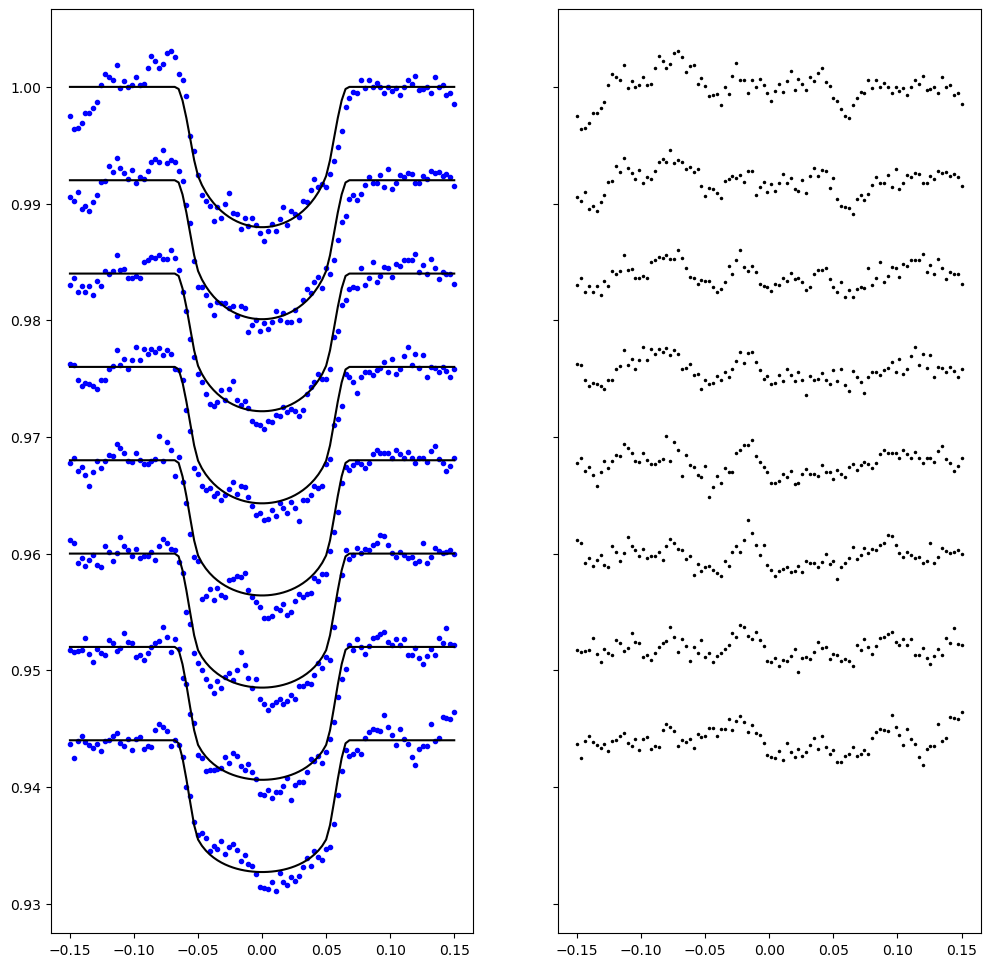

In [40]:
def plot_lightcurves(x_t, M, Y, sep = 0.008):
    N_l = x_l.shape[-1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12), sharey = True)
    for i in range(N_l):
        ax1.plot(x_t, Y[i, :] + np.arange(0, -sep*N_l, -sep)[i], 'bo', ms = 3)
        
        ax1.plot(x_t, M[i, :] + np.arange(0, -sep*N_l, -sep)[i], 'k-', ms = 3)
        ax2.plot(x_t, Y[i, :] - M[i, :] + np.arange(1, 1-sep*N_l, -sep)[i], 'k.', ms = 3)

u1_sim, u2_sim = np.linspace(0.7, 0.4, N_l), np.linspace(0.1, 0.2, N_l)
q1_sim, q2_sim = ld_to_kipping(u1_sim, u2_sim)

p_sim = {
    "T0":0.*np.ones(1),                         # Central transit time
    "P":3.4*np.ones(1),                         # Period (days)
    "a":8.*np.ones(1),                          # Semi-major axis to stellar ratio aka a/R*
    "rho":0.1*np.ones(N_l),          # Radius ratio rho aka Rp/R*
    "b":0.5*np.ones(1),                       # Impact parameter
    "q1":q1_sim, # First quadratic limb darkening coefficient
    "q2":q2_sim, # Second quadratic limb darkening coefficient
    "Foot":1.*np.ones(N_l),          # Baseline flux out of transit
    "Tgrad":0.*np.ones(N_l),          # Gradient in baseline flux (days^-1)
    "log_h":np.log(1e-3)*np.ones(1),
    "log_l_l":np.log(1000.)*np.ones(1),
    "log_l_t":np.log(0.011)*np.ones(1),
    "log_sigma":np.log(5e-4)*np.ones(N_l),
}

transit_signal = transit_2D(p_sim, x_l, x_t)
sim_noise = kernel.generate_noise(p_sim, x_l, x_t)
Y = transit_signal*(1 + sim_noise)

plot_lightcurves(x_t, transit_signal, Y)

We may also want to define a logPrior function. While PyMC can also be used to define priors on parameters, it can be useful to let ``luas.GP`` handle non-uniform priors when it comes to MCMC tuning.

The ``logPrior`` function may only take the PyTree of mean function parameters and hyperparameters as input

In [41]:
a_mean = p_sim["a"]
a_std = 0.1
b_mean = p_sim["b"]
b_std = 0.01

# Set some limb darkening priors, normally these might be generated from a package like LDTk
u1_mean = u1_sim
u1_std = 0.01
u2_mean = u2_sim
u2_std = 0.01

def logPrior(p):
    logPrior = -0.5*((p["a"] - a_mean)/a_std)**2
    logPrior += -0.5*((p["b"] - b_mean)/b_std)**2
    
    u1, u2 = ld_from_kipping(p["q1"], p["q2"])
    u1_priors = -0.5*((u1 - u1_mean)/u1_std)**2
    u2_priors = -0.5*((u2 - u2_mean)/u2_std)**2
    
    logPrior += u1_priors.sum() + u2_priors.sum()

    return logPrior.sum()

print("Log prior at simulated values:", logPrior(p_sim))

Log prior at simulated values: -1.0400021699691074e-28


We now have enough to define our ``luas.GP`` object and use it to try recover the original transmission signal injected into the correlated noise

Starting log posterior value: 4786.472048984808


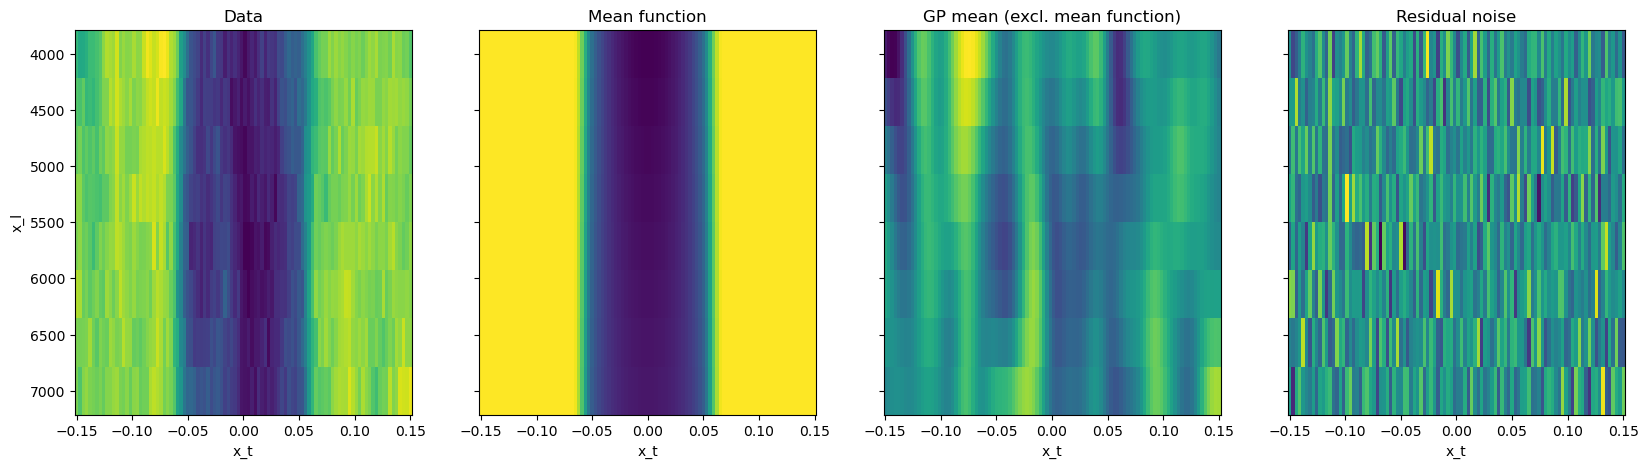

In [42]:
from luas import GP
from copy import deepcopy

# Initialise our GP object
# Make sure to include the mean function and log prior function if you're using them
gp = GP(kernel, x_l, x_t, mf = transit_2D, logPrior = logPrior)

# Initialise our starting values as the true simulated values
p_initial = deepcopy(p_sim)

# Convenient function for plotting the data and the GP fit to the data
gp.plot(p_initial, Y)
print("Starting log posterior value:", gp.logP(p_initial, Y))

Now let's begin using PyMC to perform a best-fit. We've already set the true simulated values as our initial values so we should already be close to the optimal log posterior value but for real data this won't always be the case. Similar to the approach in Fortune et al. (2024) we will not be performing any white light curve analysis but instead will be joint-fitting all spectroscopic light curves simultaneously

In [43]:
import pymc as pm
from luas.pymc_ext import LuasPyMC

# Let's define some bounds
min_log_l_l = np.log(np.diff(x_l).min())
max_log_l_l = np.log(50*(x_l[-1] - x_l[0]))

param_bounds = {
                "q1":[np.array([-10.]*N_l), np.array([10.]*N_l)],
                "q2":[np.array([-10.]*N_l), np.array([10.]*N_l)],
                "rho":[np.array([0.]*N_l), np.array([1.]*N_l)],
                "log_h":   [np.log(1e-6)*np.ones(1), np.log(1e-2)*np.ones(1)],
                "log_l_l": [min_log_l_l*np.ones(1), max_log_l_l*np.ones(1)],
                "log_sigma":[np.log(1e-6)*np.ones(N_l), np.log(1e-2)*np.ones(N_l)],
               }


def transit_model(p_fixed, Y):
    
    with pm.Model() as model:

        # Makes of copy of any parameters to be kept fixed during sampling
        var_dict = deepcopy(p_fixed)
        
        # Specify the parameters we've given bounds for
        var_dict["rho"] = pm.Uniform('rho', lower=param_bounds["rho"][0],   upper=param_bounds["rho"][1], shape=N_l)
        var_dict["q1"] = pm.Uniform('q1', lower=param_bounds["q1"][0],   upper=param_bounds["q1"][1], shape=N_l)
        var_dict["q2"] = pm.Uniform('q2', lower=param_bounds["q2"][0],   upper=param_bounds["q2"][1], shape=N_l)
        var_dict["log_h"] =   pm.Uniform("log_h", lower=param_bounds["log_h"][0], upper=param_bounds["log_h"][1], shape=1)
        var_dict["log_l_l"] = pm.Uniform("log_l_l", lower = param_bounds["log_l_l"][0], upper = param_bounds["log_l_l"][1],
                                         shape=1)
        var_dict["log_sigma"] = pm.Uniform('log_sigma', lower=param_bounds["log_sigma"][0], upper=param_bounds["log_sigma"][1],
                                           shape=N_l)
        
        # Specify the unbounded parameters
        var_dict["T0"] = pm.Flat('T0', shape=1)
        var_dict["a"] = pm.Flat('a', shape=1)
        var_dict["b"] = pm.Flat('b', shape=1)
        var_dict["Foot"] = pm.Flat('Foot', shape=N_l)
        var_dict["Tgrad"] = pm.Flat('Tgrad', shape=N_l)
        var_dict["log_l_t"] = pm.Flat('log_l_t', shape=1)

        LuasPyMC("log_like", gp = gp, var_dict = var_dict, Y = Y)
        
    return model, var_dict

# Initialise our model, p_initial will specify any fixed values like the period P
model, var_dict = transit_model(p_initial, Y)

Now we are all set up to start performing a best-fit using ``PyMC``

In [44]:
# PyMC requires the dictionary of starting values to only include variables in the model
# So we must remove the period parameter P as we keep it fixed
p_pymc = deepcopy(p_initial)
del p_pymc["P"]

# Use PyMC's maximum posteriori optimisation method
map_estimate = pm.find_MAP(
    model = model,
    include_transformed = False,
    start = p_pymc,
    maxeval = 30000,
)

# Create a new dictionary of optimised values which includes our fixed parameters
p_opt = deepcopy(p_initial)
p_opt.update(map_estimate)

print("Starting log posterior value:", gp.logP(p_initial, Y))
print("New optimised log posterior value:", gp.logP(p_opt, Y))


Starting log posterior value: 4786.472048984808
New optimised log posterior value: 4797.306414372335


Although this probably won't be needed for the simulated data and will likely clip no data points, ``luas.GP`` comes with a ``sigma_clip`` method which performs 2D Gaussian process regression and can clip outliers that deviate from a given significance value and replace them with the GP predictive mean at those locations (note we need to maintain a complete grid structure and cannot remove these data points)

Number of outliers clipped =  0


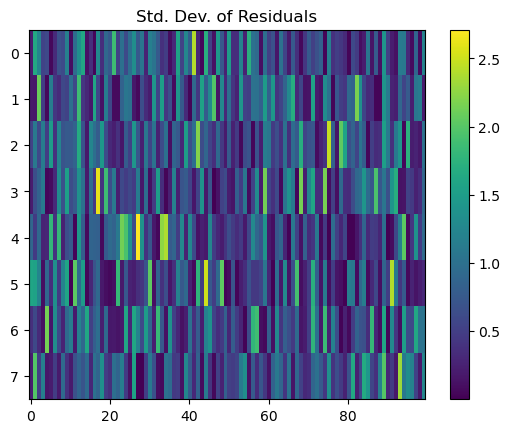

In [45]:
# This function will return a JAXArray of the same shape as Y
# but with outliers replaced with interpolated values
Y_clean = gp.sigma_clip(p_opt, # Make sure to perform sigma clipping using a good fit to the data
                        Y,     # Observations JAXArray
                        5.     # Significance level in standard deviations to clip at
                       )

For MCMC tuning with large numbers of parameters it can be very helpful to use the Laplace approximation to select a good choice of tuning matrix or "mass matrix" for No U-Turn Sampling. This can often return quite accurate approximations of the covariance matrix of the posterior especially when the data is clean enough to constrain most of the parameters.

Note that we use the ``gp.laplace_approx_with_bounds`` method instead of ``gp.laplace_approx`` because we have bounds on some of our parameters which means ``PyMC`` will perform a transformation on these parameters we would like our Laplace approximation to take account of. See the ``gp.laplace_approx_with_bounds`` documentation for more details.

In [46]:
# Returns the covariance matrix returned by the Laplace approximation
# Also returns a list of parameters which is the order the array is in
# This matches the way jax.flatten_util.ravel_pytree will sort the parameter PyTree into
cov_mat, ordered_param_list = gp.laplace_approx_with_bounds(
    p_opt,               # Make sure to use best-fit values
    Y_clean,             # The observations being fit
    param_bounds,        # Specify the same bounds that will be used for the MCMC
    fixed_vars = ["P"],  # Make sure to specify fixed parameters as otherwise they are marginalised over
    return_array = True, # May optionally return a nested PyTree if set to False which can be more readable
    regularise = True,   # Often necessary to regularise values that return negative covariance
    large = True        # For large data sets with many parameters setting this to True is more memory efficient
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:21<00:00, 10.88s/it]


No regularisation needed to remove negative values along diagonal of covariance matrix.


Build our model again using the same parameters being varied and sample all parameters using NUTS. Note that ``PyMC`` has far more options for sampling here and can easily do blocked Gibbs sampling with multiple NUTS steps or you can intermix NUTS sampling with other methods such as slice sample, etc.

In [47]:
# Initialise our PyMC model
model, var_dict = transit_model(p_opt, Y_clean)

# The NUTS step takes as input the variables created when initialising the model
# We also sort these variables in the same order our Laplace approximated covariance matrix is in
NUTS_model_vars = [var_dict[par] for par in ordered_param_list]
NUTS_step = pm.NUTS(NUTS_model_vars, scaling = cov_mat, is_cov = True, model = model)

# Begin MCMC sampling
idata = pm.sample(
    model = model,
    step = NUTS_step,
    initvals = map_estimate,
    draws = 1000,
    tune = 1000,
    chains = 2,
    cores = 1, # This will probably fail if not set to 1 as I don't think PyMC can parallelise JAX functions
)

INFO:pymc:Sequential sampling (2 chains in 1 job)
INFO:pymc:NUTS: [Foot, T0, Tgrad, a, b, log_h, log_l_l, log_l_t, log_sigma, q1, q2, rho]


INFO:pymc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 283 seconds.


Print a summary of the samples using ``arviz``

In [52]:
az.summary(idata, round_to = 4)

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
T0[0]         0.0006  0.0004 -0.0002   0.0014     0.0000   0.0000  3517.1407   
a[0]          7.9737  0.0596  7.8525   8.0772     0.0010   0.0007  3264.2913   
b[0]          0.4988  0.0090  0.4822   0.5155     0.0001   0.0001  4599.8597   
Foot[0]       0.9998  0.0004  0.9990   1.0006     0.0000   0.0000  2899.7754   
Foot[1]       0.9998  0.0004  0.9990   1.0006     0.0000   0.0000  2904.0181   
Foot[2]       0.9999  0.0004  0.9991   1.0007     0.0000   0.0000  2774.6899   
Foot[3]       0.9998  0.0004  0.9991   1.0006     0.0000   0.0000  2863.0335   
Foot[4]       1.0000  0.0004  0.9992   1.0008     0.0000   0.0000  2866.4592   
Foot[5]       1.0000  0.0004  0.9992   1.0007     0.0000   0.0000  2755.8105   
Foot[6]       0.9999  0.0004  0.9991   1.0008     0.0000   0.0000  2736.7175   
Foot[7]       1.0000  0.0004  0.9992   1.0008     0.0000   0.0000  2706.9424   
Tgrad[0]      0.0000  0.0002 -0.0003   0.0003     0.0000   0.0000  2368.6674   
Tgrad[1]     -0.0000  0.0002 -0.0003   0.0003     0.0000   0.0000  2262.7024   
Tgrad[2]      0.0000  0.0002 -0.0003   0.0003     0.0000   0.0000  2102.3844   
Tgrad[3]     -0.0001  0.0002 -0.0004   0.0002     0.0000   0.0000  2161.3512   
Tgrad[4]     -0.0000  0.0002 -0.0003   0.0003     0.0000   0.0000  2182.5873   
Tgrad[5]      0.0000  0.0002 -0.0003   0.0003     0.0000   0.0000  2258.5458   
Tgrad[6]      0.0000  0.0002 -0.0003   0.0004     0.0000   0.0000  2571.2631   
Tgrad[7]      0.0001  0.0002 -0.0002   0.0004     0.0000   0.0000  2627.3740   
log_l_t[0]   -4.4299  0.0705 -4.5551  -4.2906     0.0015   0.0011  2176.2487   
rho[0]        0.0982  0.0035  0.0916   0.1045     0.0001   0.0000  2553.4272   
rho[1]        0.0997  0.0034  0.0933   0.1059     0.0001   0.0001  2248.2912   
rho[2]        0.1009  0.0033  0.0948   0.1070     0.0001   0.0001  2097.5117   
rho[3]        0.1013  0.0032  0.0949   0.1071     0.0001   0.0000  2237.4268   
rho[4]        0.1030  0.0031  0.0971   0.1086     0.0001   0.0000  2395.8759   
rho[5]        0.1021  0.0030  0.0963   0.1079     0.0001   0.0000  2225.4743   
rho[6]        0.1001  0.0032  0.0940   0.1060     0.0001   0.0000  2227.3445   
rho[7]        0.0993  0.0033  0.0930   0.1054     0.0001   0.0000  2709.8261   
q1[0]         0.6383  0.0218  0.6014   0.6847     0.0003   0.0002  4500.8938   
q1[1]         0.5943  0.0221  0.5528   0.6355     0.0004   0.0003  3711.6481   
q1[2]         0.5528  0.0205  0.5160   0.5944     0.0003   0.0002  5613.3955   
q1[3]         0.5132  0.0193  0.4767   0.5484     0.0003   0.0002  4445.3153   
q1[4]         0.4709  0.0179  0.4350   0.5031     0.0003   0.0002  4448.7884   
q1[5]         0.4268  0.0170  0.3948   0.4589     0.0003   0.0002  4162.7149   
q1[6]         0.3980  0.0178  0.3648   0.4315     0.0003   0.0002  4648.5640   
q1[7]         0.3602  0.0166  0.3275   0.3896     0.0002   0.0002  4674.2825   
q2[0]         0.4377  0.0056  0.4277   0.4486     0.0001   0.0001  4289.3465   
q2[1]         0.4261  0.0058  0.4155   0.4370     0.0001   0.0001  3817.0322   
q2[2]         0.4137  0.0059  0.4023   0.4245     0.0001   0.0001  4486.7078   
q2[3]         0.3996  0.0055  0.3894   0.4095     0.0001   0.0001  4066.8047   
q2[4]         0.3854  0.0059  0.3750   0.3972     0.0001   0.0001  4049.8386   
q2[5]         0.3701  0.0058  0.3589   0.3805     0.0001   0.0001  4708.7083   
q2[6]         0.3521  0.0060  0.3414   0.3634     0.0001   0.0001  4902.2086   
q2[7]         0.3334  0.0060  0.3217   0.3445     0.0001   0.0001  4329.9357   
log_h[0]     -6.7967  0.1364 -7.0439  -6.5361     0.0035   0.0025  1598.9098   
log_l_l[0]    6.9712  0.1100  6.7707   7.1806     0.0025   0.0017  2011.0280   
log_sigma[0] -7.5232  0.0827 -7.6661  -7.3499     0.0012   0.0009  4620.0188   
log_sigma[1] -7.6229  0.0797 -7.7867  -7.4822     0.0011   0.0008  4849.7550   
log_sigma[2] -7.6211  0.0778 -7.7600  -7.4643     0.0012   0.0009  3952.1322   
log_sigma[3] -7.

The ``arviz.plot_trace`` function can be very useful for visualising the marginal posterior distributions of the different parameters as well as to examine the chains and diagnose any possible convergence issues.

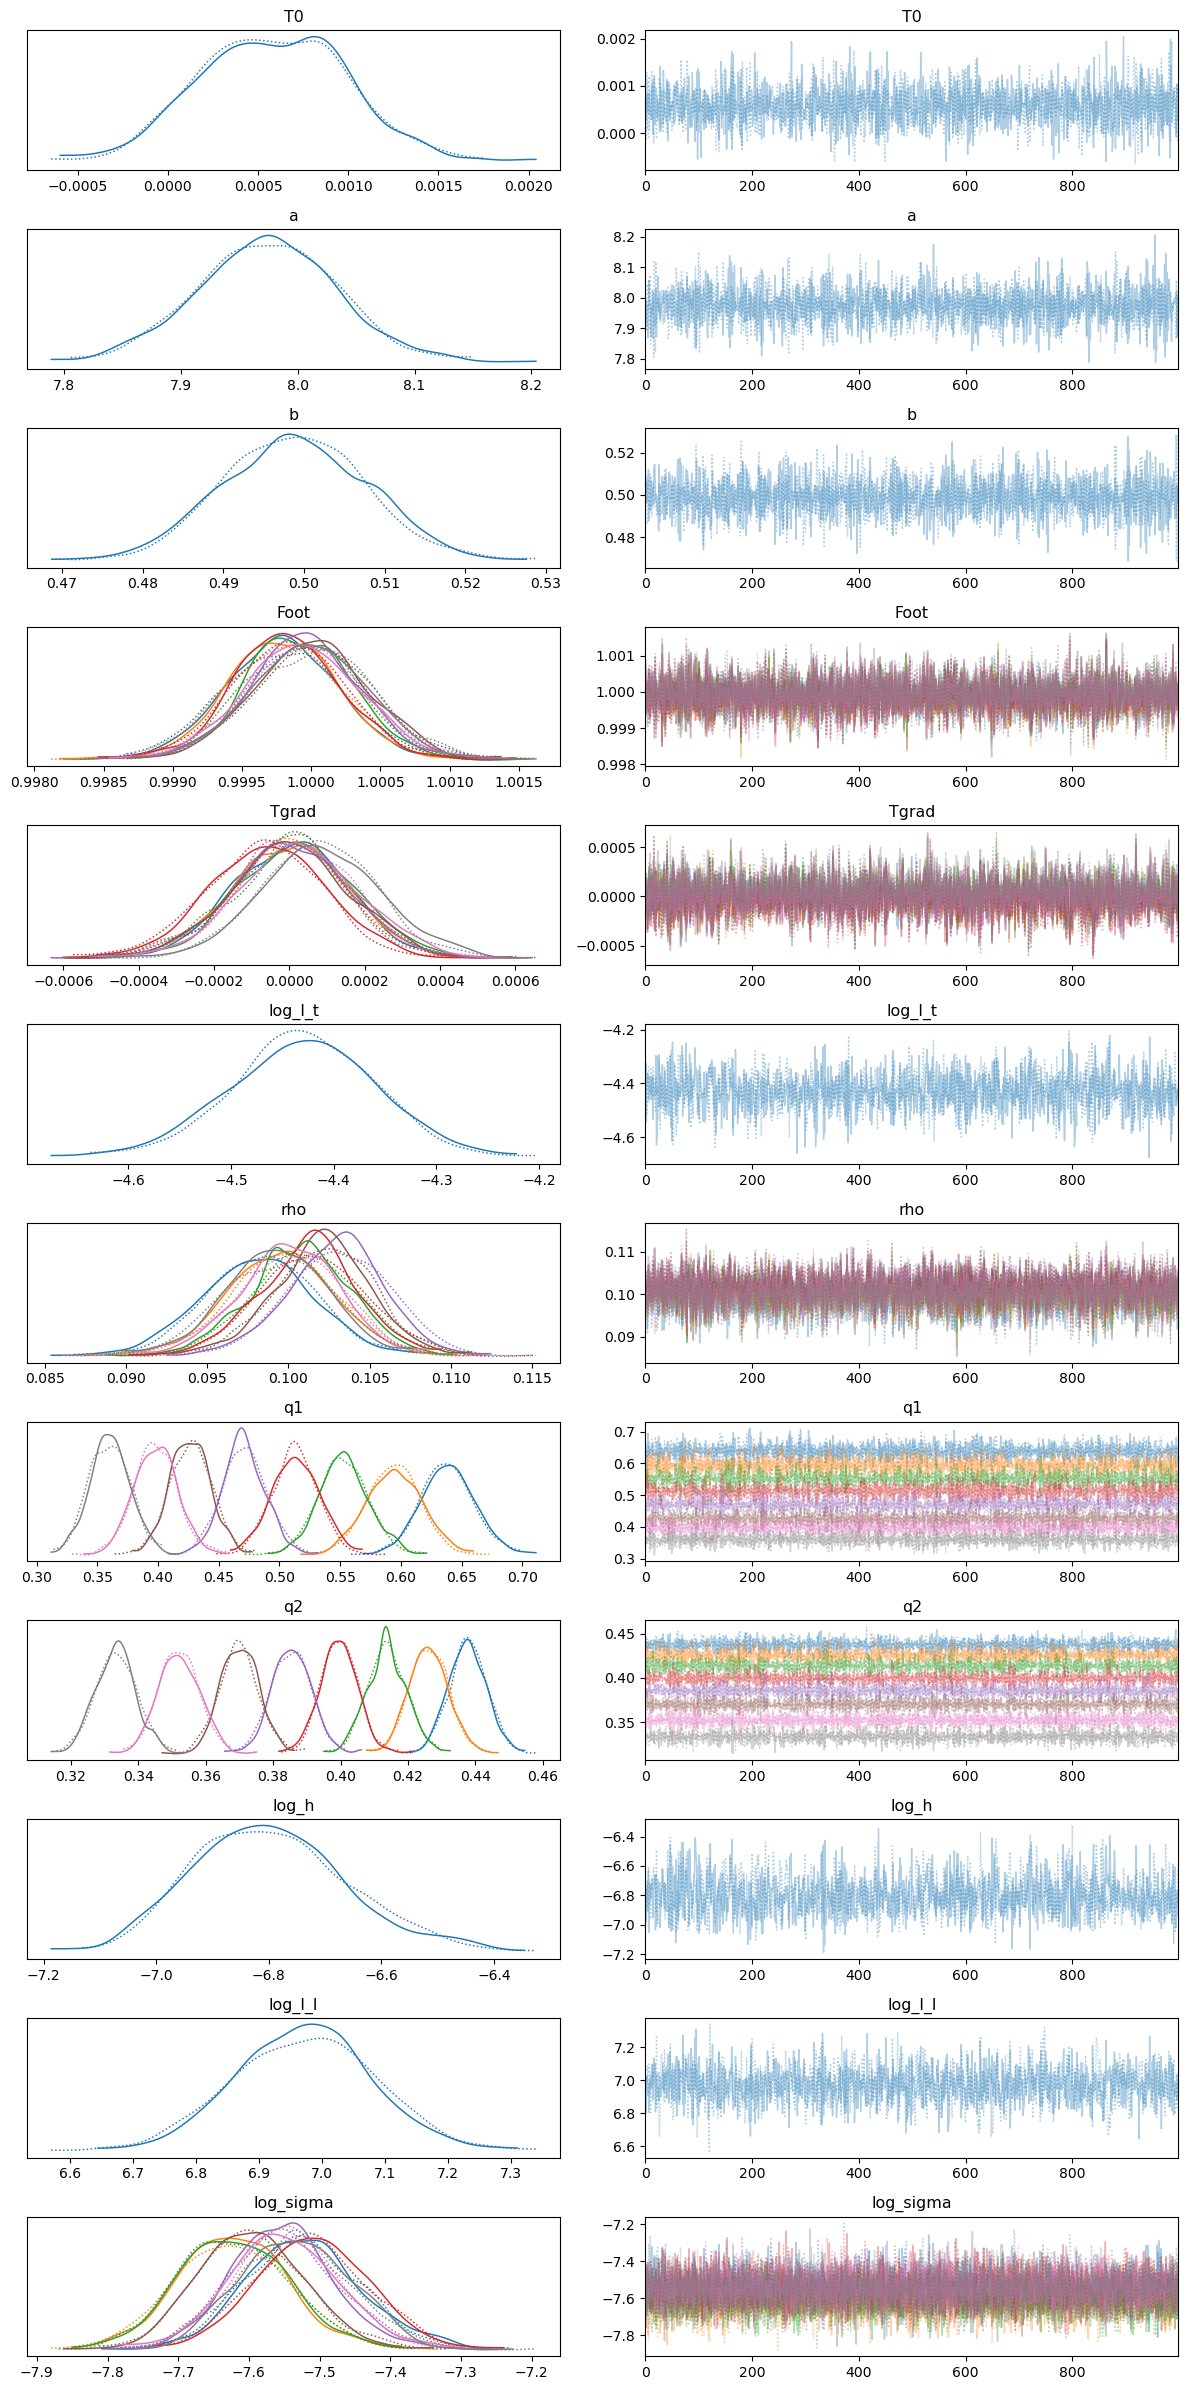

In [53]:
trace_plot = az.plot_trace(idata, divergences = None)
plt.tight_layout()

``corner`` is a great module to use for generating corner plots. Unfortunately when fitting many light curves the number of parameters can make visualising the full corner plot quite unwieldly but we can always just plot subsets of parameters instead

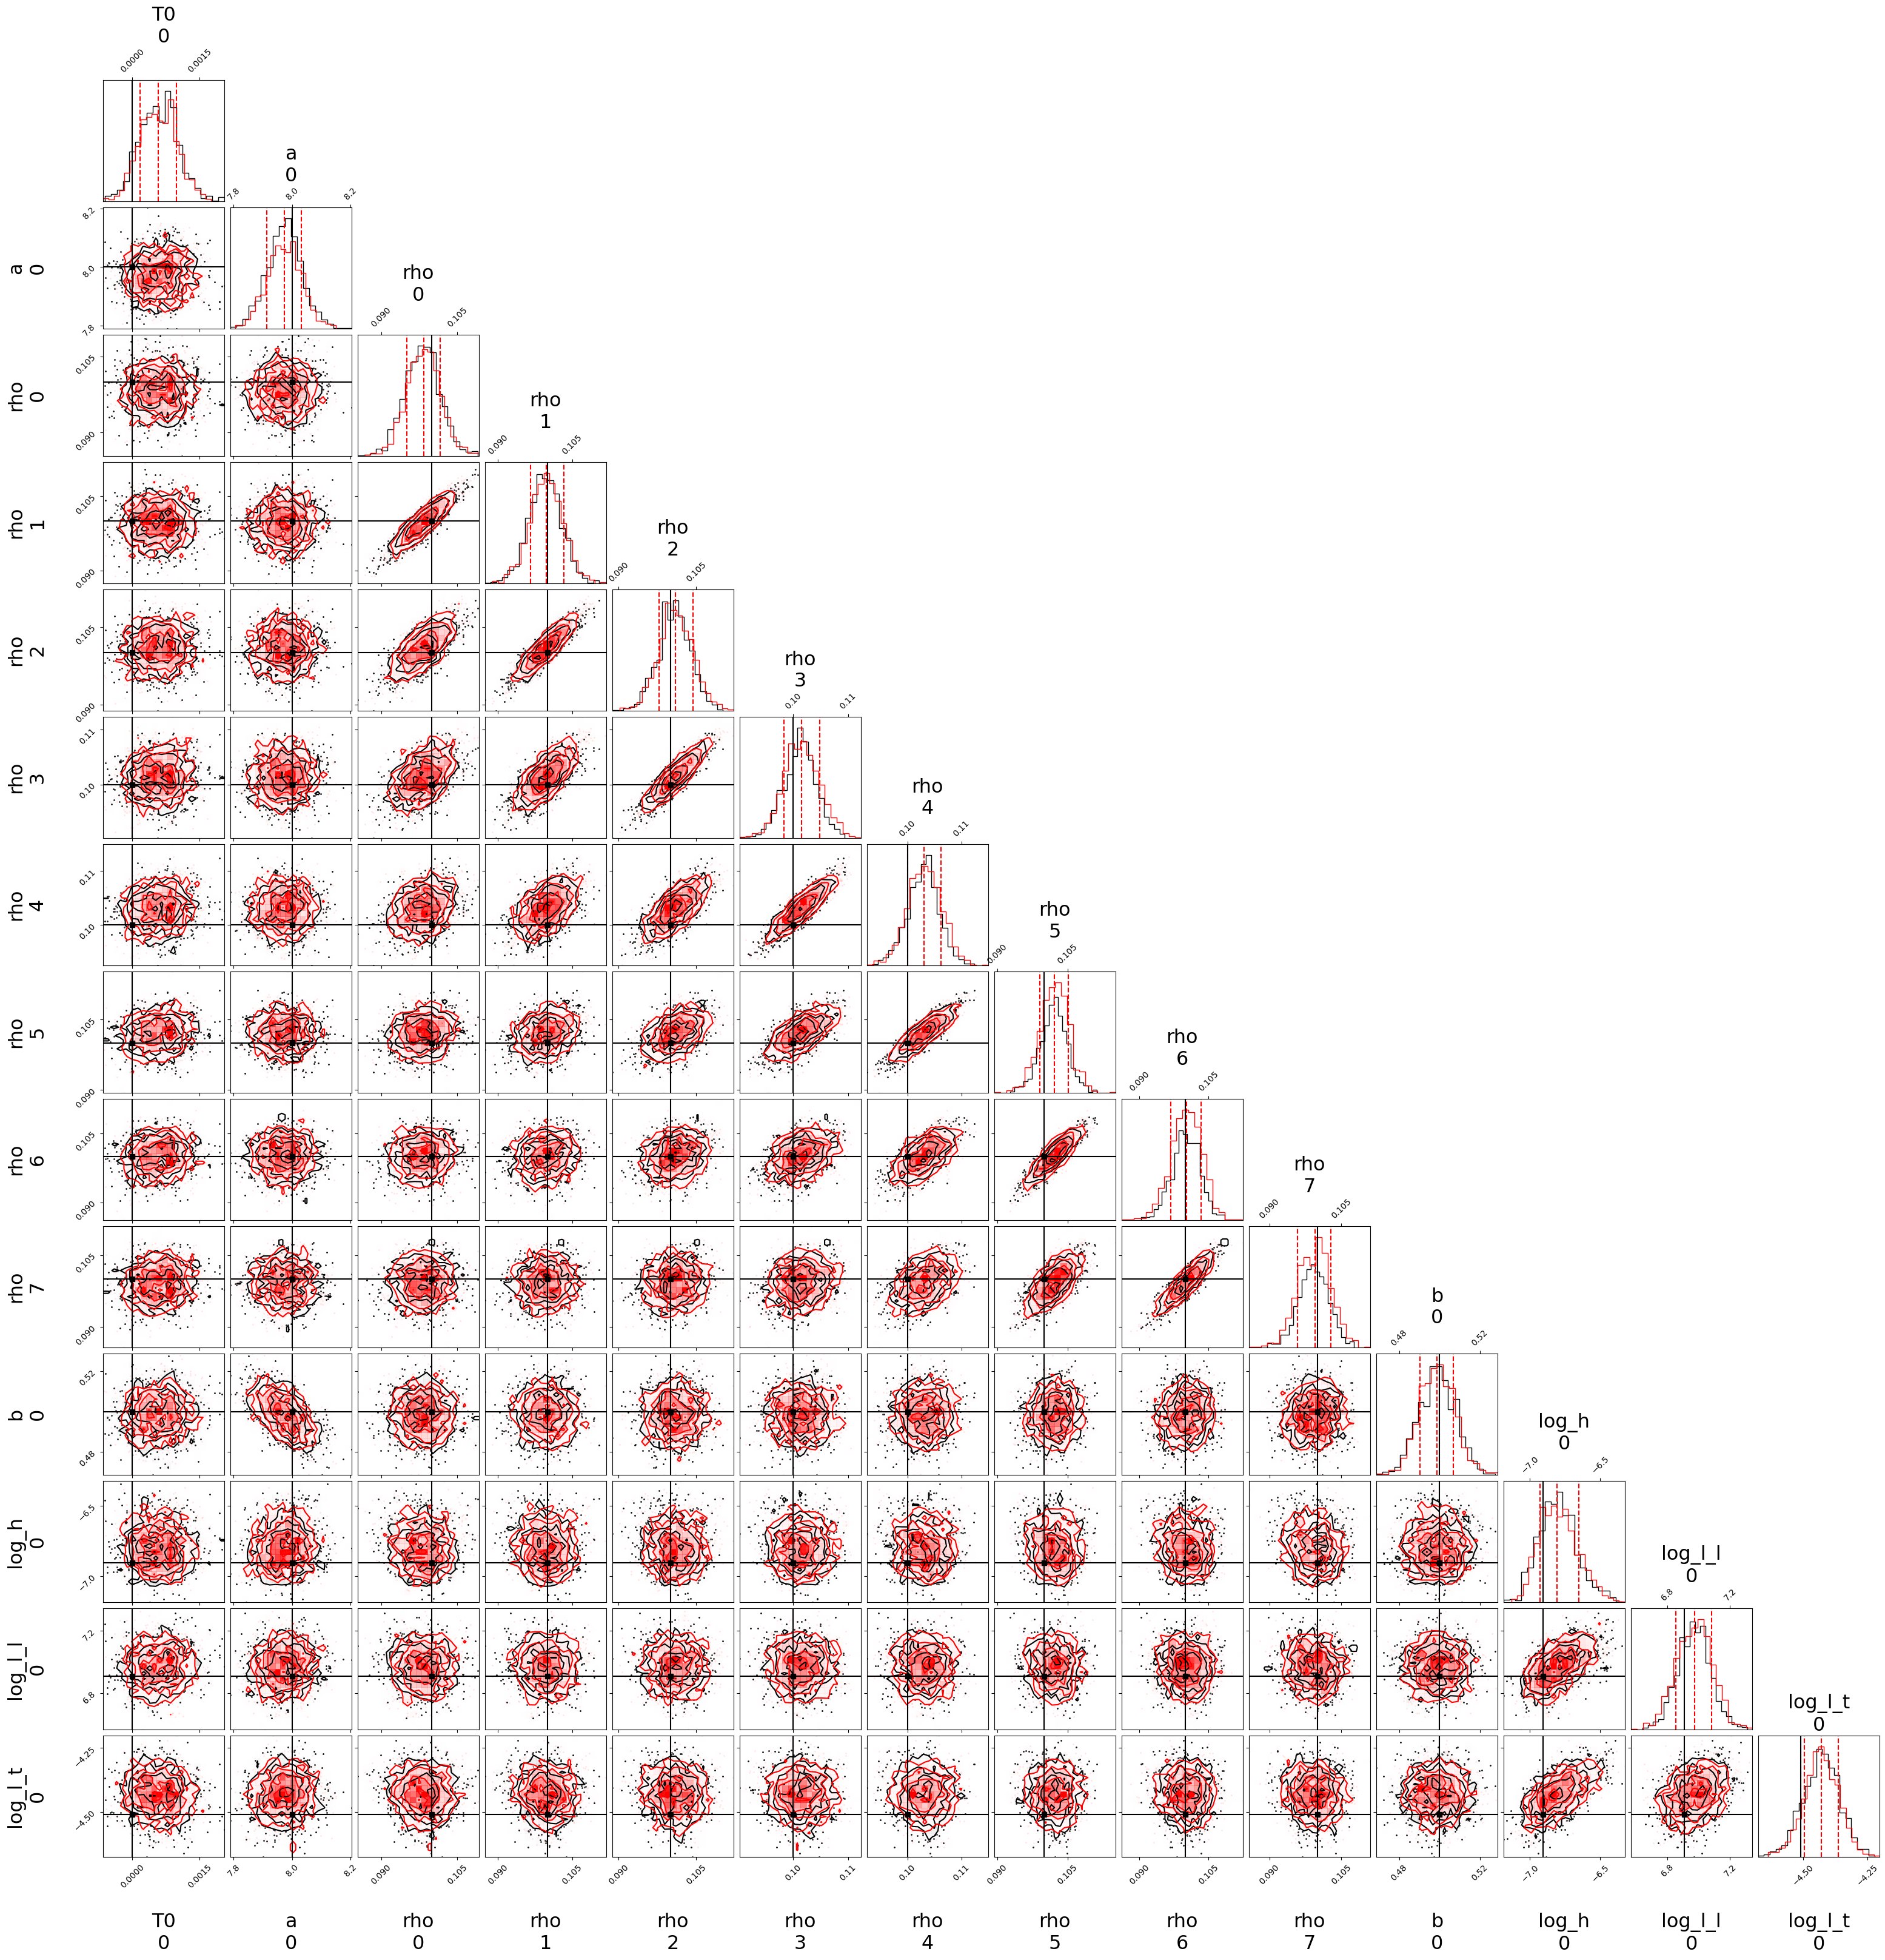

In [57]:
from corner import corner

idata_corner1 = idata.sel(chain=[0])
idata_corner2 = idata.sel(chain=[1])

params = ["T0", "a", "rho", "b", "log_h", "log_l_l", "log_l_t"]

fig1 = corner(idata_corner1, smooth = 0.4, var_names = params, data_kwargs = {"alpha":1.})
fig2 = corner(idata_corner2, quantiles=[0.16, 0.5, 0.84], title_fmt = None, title_kwargs={"fontsize": 23},
              label_kwargs={"fontsize": 23}, show_titles=True, smooth = 0.4, color = "r", fig = fig1,
              top_ticks = True, max_n_ticks = 2, labelpad = 0.16, var_names = params,
              truths = p_sim, truth_color = "k",
              )

If you want to examine the chains for any parameters you can use ``idata.posterior[param]`` to get an ``xarray.DataArray`` object and can use the ``to_numpy`` method to convert to a ``NumPy`` array

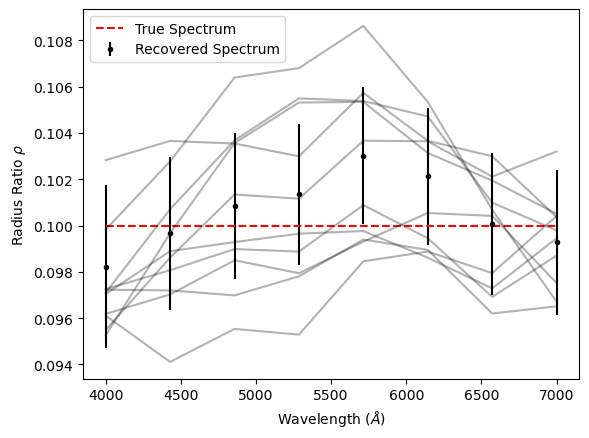

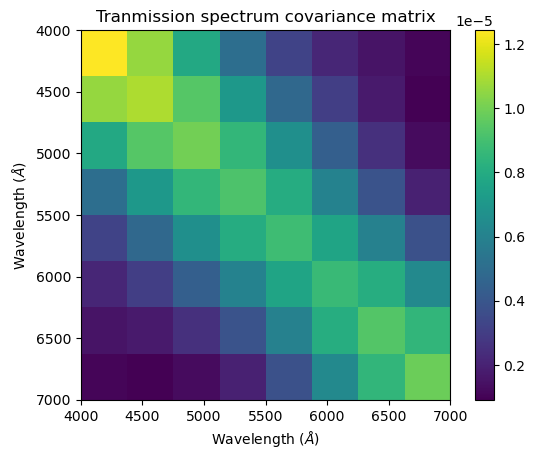

In [58]:
# NumPy array of MCMC samples of shape (N_chains, N_draws, N_l)
rho_chains = idata.posterior["rho"].to_numpy()

# Get the mean radius ratio values averaged over all chains and draws
rho_mean = rho_chains.mean((0, 1))

# Calculate the covariance matrix of each chain and average together
N_chains = rho_chains.shape[0]
rho_cov = jnp.zeros((N_l, N_l))
for i in range(N_chains):
    rho_cov += jnp.cov(rho_chains[0, :, :].T)
rho_cov /= N_chains

# Standard deviation given by sqrt of diagonal of covariance matrix
rho_std_dev = jnp.sqrt(jnp.diag(rho_cov))


# We can plot our recovered spectrum against the simulated true spectrum
plt.errorbar(x_l, rho_mean, yerr = rho_std_dev, fmt = 'k.', label = "Recovered Spectrum")
plt.plot(x_l, p_sim["rho"], 'r--', label = "True Spectrum")

# Select a few samples from the MCMC to help visualise the correlation between values
rho_draws = rho_chains[0, 0:1000:100, :].T
plt.plot(x_l, rho_draws, 'k-', alpha = 0.3)
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel(r"Radius Ratio $\rho$")
plt.legend()
plt.show()

plt.title("Tranmission spectrum covariance matrix")
plt.imshow(rho_cov, extent = [x_l[0], x_l[-1], x_l[-1], x_l[0]])
plt.colorbar()
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("Wavelength ($\AA$)")
plt.show()

It can be hard to tell when there are significant correlations involved whether the recovered spectrum is actually consistent with the simulated spectrum. The reduced chi-squared statistic $\chi_r^2$ is useful for determining this. It is calculated using:

$$
\begin{equation}
    \chi_\mathrm{r}^2 = (\bar{\vec{\rho}}_\mathrm{ret} - \vec{\rho}_\mathrm{inj})^T \mathbf{K}_\mathrm{\vec{\rho}; ret}^{-1} (\bar{\vec{\rho}}_\mathrm{ret} - \vec{\rho}_\mathrm{inj}) / N_l,
\end{equation}
$$

Where $\bar{\vec{\rho}}_\mathrm{ret}$ is our retrieved mean transmission spectrum, $\vec{\rho}_\mathrm{inj}$ is the injected transmission spectrum and $\mathbf{K}_\mathrm{\vec{\rho}; ret}$ is our retrieved covariance matrix of the transmission spectrum

In [60]:
r = rho_mean - p_sim["rho"]
chi2_r = r.T @ jnp.linalg.inv(rho_cov) @ r / N_l

print("Reduced chi-squared value:", chi2_r)

# The reduced chi-squared distribution always has mean 1 but has different standard deviations
# depending on the numbers of degrees of freedom
print("Distribution of reduced chi-squared: mean = 1, std. dev. =", jnp.sqrt(2/N_l))

Reduced chi-squared value: 0.7582835919766896
Distribution of reduced chi-squared: mean = 1, std. dev. = 0.5


In [61]:
idata

Inference data with groups:
	> posterior
	> sample_stats